### 선형회귀기반 분류 알고리즘 학습 - LogisticRegression + 교차검증

- 이진분류 및 다중분류 가능
- 분류지만 선형회귀식기반의 알고리즘이라서 Regresion

[1] 모듈로딩 및 데이터 준비 <hr>

In [340]:
## [1-1] 모듈로딩 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt 

#### [1] 데이터 준비 및 확인

In [341]:
## [1-2] 데이터 준비 
filename='../data/iris.csv'

In [342]:
## 데이터 로딩
irisDF= pd.read_csv(filename)
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa


[2] 데이터 확인<hr>

- 2개 품종만 추출 ==> 'Setosa', 'Versicolor'

In [343]:
## 품종 컬럼의 고유값 확인
irisDF.variety.unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [344]:
## boolean Index 사용해서 2개 품종 데이터 추출 
dataDF=irisDF[irisDF.variety != 'Virginica'].copy()
dataDF.shape 

(100, 5)

- 2개 품종 식별 가능한 피쳐 선택

In [345]:
dataDF[dataDF['variety'] == 'Setosa']['petal.length']

0     1.4
1     1.4
2     1.3
3     1.5
4     1.4
5     1.7
6     1.4
7     1.5
8     1.4
9     1.5
10    1.5
11    1.6
12    1.4
13    1.1
14    1.2
15    1.5
16    1.3
17    1.4
18    1.7
19    1.5
20    1.7
21    1.5
22    1.0
23    1.7
24    1.9
25    1.6
26    1.6
27    1.5
28    1.4
29    1.6
30    1.6
31    1.5
32    1.5
33    1.4
34    1.5
35    1.2
36    1.3
37    1.4
38    1.3
39    1.5
40    1.3
41    1.3
42    1.3
43    1.6
44    1.9
45    1.4
46    1.6
47    1.4
48    1.5
49    1.4
Name: petal.length, dtype: float64

In [346]:
SETO = dataDF['variety'] == 'Setosa'
VESI = dataDF['variety'] == 'Versicolor'

In [347]:
dataDF[SETO]['petal.length']

0     1.4
1     1.4
2     1.3
3     1.5
4     1.4
5     1.7
6     1.4
7     1.5
8     1.4
9     1.5
10    1.5
11    1.6
12    1.4
13    1.1
14    1.2
15    1.5
16    1.3
17    1.4
18    1.7
19    1.5
20    1.7
21    1.5
22    1.0
23    1.7
24    1.9
25    1.6
26    1.6
27    1.5
28    1.4
29    1.6
30    1.6
31    1.5
32    1.5
33    1.4
34    1.5
35    1.2
36    1.3
37    1.4
38    1.3
39    1.5
40    1.3
41    1.3
42    1.3
43    1.6
44    1.9
45    1.4
46    1.6
47    1.4
48    1.5
49    1.4
Name: petal.length, dtype: float64

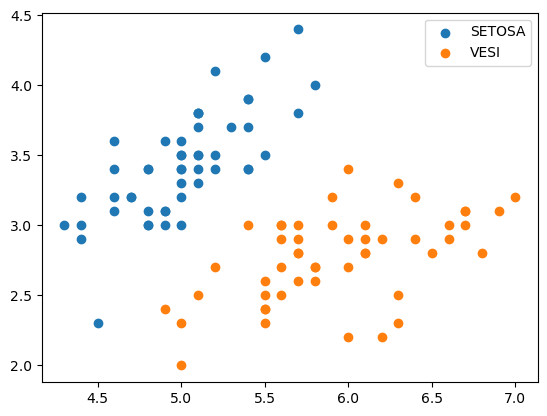

In [348]:
plt.scatter(dataDF[SETO]['sepal.length'], dataDF[SETO]['sepal.width'], label='SETOSA')
plt.scatter(dataDF[VESI]['sepal.length'], dataDF[VESI]['sepal.width'], label='VESI')

plt.legend()
plt.show()

- 꽃잎의 길이와 너비(petal.length, petal.width) 특성만 추출

In [349]:
dataDF.columns

Index(['sepal.length', 'sepal.width', 'petal.length', 'petal.width',
       'variety'],
      dtype='object')

In [350]:
dataDF=dataDF[dataDF.columns[2:]].copy()

In [351]:
dataDF.shape

(100, 3)

In [352]:
dataDF.head(3)

,petal.length,petal.width,variety
0,1.4,0.2,Setosa
1,1.4,0.2,Setosa
2,1.3,0.2,Setosa


In [353]:
## - 품종컬럼 문자열 ==> 수치형태 변환한 컬럼 추가 
pd.set_option('future.no_silent_downcasting', True)
labelToNum={'Setosa' : 0, 'Versicolor':1}
dataDF['variety_no']=dataDF.variety.replace(labelToNum )

In [354]:
dataDF.head(3)

,petal.length,petal.width,variety,variety_no
0,1.4,0.2,Setosa,0
1,1.4,0.2,Setosa,0
2,1.3,0.2,Setosa,0


In [355]:
dataDF.corr(numeric_only=True)

,petal.length,petal.width
petal.length,1.000000,0.979322
petal.width,0.979322,1.000000


#### [2] 데이터 가공

- 피쳐/특성/독립과 타겟/클래스/종속변수 분리

In [356]:
featureDF = dataDF[dataDF.columns[:2]]
classDF = dataDF.variety_no

In [357]:
# object 타입 ==> int 타입으로 변환
classDF=classDF.astype('int')
classDF

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Name: variety_no, Length: 100, dtype: int64

In [358]:
print(f'featureDF : {featureDF.shape}  classDF : {classDF.shape}')

featureDF : (100, 2)  classDF : (100,)


- 훈련용/테스트용 분리

In [359]:
## - 분류시에는 훈련용/테스트용에 동일한 비율로 타겟이 배분 
## - stratify 매개변수 : 타겟 데이터셋의 클래스/라벨 비율에 맞게 학습용/테스트용 분리 
train_X, test_X, train_y, test_y = train_test_split(featureDF, classDF,
                                                    random_state=7,
                                                    test_size=0.2,
                                                    stratify=classDF)

In [360]:
print(f'[TRAIN] train_X : {train_X.shape}   train_y : {train_y.shape}')
print(f'[TEST] test_X : {test_X.shape} test_y : {test_y.shape}')

[TRAIN] train_X : (80, 2)   train_y : (80,)
[TEST] test_X : (20, 2) test_y : (20,)


In [361]:
## 데이터셋별로 클래스 개수 확인 
test_y.value_counts(), train_y.value_counts()

(variety_no
 1    10
 0    10
 Name: count, dtype: int64,
 variety_no
 1    40
 0    40
 Name: count, dtype: int64)

- 특성/피쳐 2개에 대한 스케일링 진행 ==> 피쳐의 값의 범위 일치 

In [362]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [363]:
## StandardScaler : 평균 0, 표준편차 1 즉, 정규 분포 따르도록 스케일링 
## 훈련용 DataSet 기반의 스케일러는 테스트용 DS, 사용자 데이터에 대해 스케일링 진행함 
scaler = StandardScaler()

scaler.fit(train_X)

StandardScaler()

In [364]:
## fit() 후에 설정되는 파라미터들 ==> 모델 파라미터 
print(scaler.var_, scaler.mean_)

[2.12549375 0.32415   ] [2.8725 0.79  ]


In [365]:
# 훈련데이터와 테스트 데이터 스케일링 진행
# ==> 훈련용 생성한 스케일러로 훈련용, 테스트용 변환 진행 
# ==> 향후 임의의 새로운 데이터 예측(predict)시에도 해당 스케일러 적용
train_scaled_X = scaler.transform(train_X)
test_scaled_X = scaler.transform(test_X)

#### [3] 학습 
- 메인학습 : 지도학습 - 분류
- 세부학습 : 선형모델 로지스틱회귀 => 선형회귀 선형식 => 확률로 변환 : sigmoid(선형식) 

In [366]:
# 모듈로딩
# - 알고리즘 모델
from sklearn.linear_model import LogisticRegression
# - 모델성능평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
# - 손실 계산
from sklearn.metrics import log_loss







In [367]:
# [3-1] 학습
lr_model = LogisticRegression()
lr_model.fit(train_scaled_X, train_y)


LogisticRegression()

In [368]:
# - 모델 파라미터ㅐ

print(lr_model.coef_, lr_model.n_features_in_)
print(lr_model.intercept_)
print(lr_model.classes_)

[[2.03218022 1.8833978 ]] 2
[0.25012681]
[0 1]


In [369]:
#  선형식 : y = W1*X1 + W2*X2 + b
W1, W2 = lr_model.coef_[0][0], lr_model.coef_[0][1]

b = lr_model.intercept_ 

y1 = train_scaled_X[:,0] * W1 + train_scaled_X[:,1]*W2 + b
print(y1)

# -> 메서드 decision_function()

y2 = lr_model.decision_function(train_scaled_X)

print(y1,y2)

[ 3.92701598 -3.47534967  4.81537956 -3.05717901  5.00679204 -3.94554259
  3.78762576 -3.94554259 -3.75413011  3.50884532  3.78762576  6.27798058
 -4.31169099 -3.42332741  4.86740182  4.3972089  -3.56271763  2.56845948
  4.20579642 -3.61473989 -3.00515675  4.86740182 -3.75413011  6.03454584
 -3.89352033 -4.08493281 -3.47534967  4.95476978 -2.15213887 -2.95313449
 -3.89352033  1.54070568 -3.47534967  5.14618226 -4.08493281 -3.47534967
  2.09826656 -2.95313449 -3.89352033 -2.81374427 -3.42332741  3.50884532
  5.4249627   4.3972089  -4.03291055 -3.61473989 -3.56271763  3.7002578
  4.86740182  1.81948612  3.64823554  4.34518664  5.47698496  4.44923116
  5.4249627  -3.75413011  3.0386524  -3.61473989 -2.95313449 -4.50310347
 -2.67435405  4.0664062   2.65582744  3.7356035   3.45682306 -3.33595945
  3.17804262 -3.23191493 -3.75413011  3.50884532 -3.61473989  6.22595832
 -3.61473989 -3.42332741 -3.89352033 -3.75413011  2.95128444  4.86740182
  2.51643722  2.7078497 ]
[ 3.92701598 -3.47534967  

In [370]:
# - 선형식 => 확률 값으로 변환
from scipy.special import expit

# - 양성 즉, 1일 확률 값
one_p = expit(y)

# - 0일 확률값	
zero_p = 1 - one_p
# 
total_p = np.concatenate([one_p,zero_p])
total_p

array([0.98067831, 0.0300218 , 0.991961  , 0.04490855, 0.99335215,
       0.01897375, 0.97785232, 0.01897375, 0.02288483, 0.9709384 ,
       0.97785232, 0.99812633, 0.01323338, 0.03157433, 0.99236541,
       0.98783808, 0.02757945, 0.92880389, 0.9853101 , 0.02621804,
       0.04719345, 0.99236541, 0.02288483, 0.99761114, 0.01996671,
       0.0165459 , 0.0300218 , 0.99299965, 0.10413152, 0.04958858,
       0.01996671, 0.82356729, 0.0300218 , 0.99421211, 0.0165459 ,
       0.0300218 , 0.89073458, 0.04958858, 0.01996671, 0.05658596,
       0.03157433, 0.9709384 , 0.99561409, 0.98783808, 0.01741405,
       0.02621804, 0.02757945, 0.97587905, 0.99236541, 0.86050445,
       0.97462369, 0.98719696, 0.9958355 , 0.98844747, 0.99561409,
       0.02288483, 0.95429008, 0.02621804, 0.04958858, 0.01095327,
       0.06450373, 0.98314992, 0.93436925, 0.97669721, 0.96943397,
       0.03435796, 0.95999957, 0.03798221, 0.02288483, 0.9709384 ,
       0.02621804, 0.99802647, 0.02621804, 0.03157433, 0.01996

In [371]:
# -> predict_proba()

lr_model.predict_proba(train_scaled_X) 

array([[0.01932169, 0.98067831],
       [0.9699782 , 0.0300218 ],
       [0.008039  , 0.991961  ],
       [0.95509145, 0.04490855],
       [0.00664785, 0.99335215],
       [0.98102625, 0.01897375],
       [0.02214768, 0.97785232],
       [0.98102625, 0.01897375],
       [0.97711517, 0.02288483],
       [0.0290616 , 0.9709384 ],
       [0.02214768, 0.97785232],
       [0.00187367, 0.99812633],
       [0.98676662, 0.01323338],
       [0.96842567, 0.03157433],
       [0.00763459, 0.99236541],
       [0.01216192, 0.98783808],
       [0.97242055, 0.02757945],
       [0.07119611, 0.92880389],
       [0.0146899 , 0.9853101 ],
       [0.97378196, 0.02621804],
       [0.95280655, 0.04719345],
       [0.00763459, 0.99236541],
       [0.97711517, 0.02288483],
       [0.00238886, 0.99761114],
       [0.98003329, 0.01996671],
       [0.9834541 , 0.0165459 ],
       [0.9699782 , 0.0300218 ],
       [0.00700035, 0.99299965],
       [0.89586848, 0.10413152],
       [0.95041142, 0.04958858],
       [0.

In [372]:
# -> predict()

lr_model.predict(train_scaled_X)

array([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1])

#	[4] 성능평가 <hr>


In [373]:
# 훈련용 성능과 테스트용 성능평가
# [1] 모델의 성능평가 메서드 : score() => accuracy 로 성능평가 결과 반환
train_score = lr_model.score(train_scaled_X, train_y)
test_score = lr_model.score(test_scaled_X, test_y)

print(f'[Train] score : {train_score}, [Test] score : {test_score}')

[Train] score : 1.0, [Test] score : 1.0


In [374]:
# [2] 다양한 성능평가 지표
print('[Train]-------------------------')
train_pre = lr_model.predict(train_scaled_X)
print(f'정확도 : {accuracy_score(train_y,train_pre)}')
print(f'정밀도 : {precision_score(train_y,train_pre)}')
print(f'재현율 : {recall_score(train_y,train_pre)}')
print(f'f1 점수 : {f1_score(train_y,train_pre)}')

[Train]-------------------------
정확도 : 1.0
정밀도 : 1.0
재현율 : 1.0
f1 점수 : 1.0


In [375]:
# [2-1] 다양한 성능평가 지표
print('[Test]-------------------------')
test_pre = lr_model.predict(test_scaled_X)
print(f'정확도 : {accuracy_score(test_y,test_pre)}')
print(f'정밀도 : {precision_score(test_y,test_pre)}')
print(f'재현율 : {recall_score(test_y,test_pre)}')
print(f'f1 점수 : {f1_score(test_y,test_pre)}')

[Test]-------------------------
정확도 : 1.0
정밀도 : 1.0
재현율 : 1.0
f1 점수 : 1.0


In [376]:
# [3] 손실/비용 계산 => 확률값으로
# 
proba = lr_model.predict_proba(train_scaled_X)

# log_loss()

train_loss = log_loss(train_y, proba)





In [377]:
# [3-1] 손실/비용 계산 => 확률값으로
# 
proba = lr_model.predict_proba(train_scaled_X)
proba_test = lr_model.predict_proba(test_scaled_X)

# log_loss()

train_loss = log_loss(train_y, proba)
test_loss = log_loss(test_y, proba_test)

In [378]:
print(f'[Train Loss] {train_loss}, [Test Loss] {test_loss}')

[Train Loss] 0.03213373711906877, [Test Loss] 0.05160227004900856


# [교차검증 과 튜닝]

[1] 간편한 교차검증 <hr>

In [379]:
# 모듈로딩
# 간편한 교차검증용 함수들
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import cross_validate

In [380]:
# - CV 후 score 만 확인
cross_val_score(lr_model, train_scaled_X, train_y, cv=3, scoring='f1')

array([1., 1., 1.])

In [381]:
# - cv 후 predict 한 결과만 반환
pred = cross_val_predict(lr_model, train_scaled_X, train_y)
pred.shape

(80,)

In [382]:
pred = cross_val_predict(lr_model, train_scaled_X, train_y, method='predict_proba')
pred[:3]

array([[0.02190101, 0.97809899],
       [0.96422758, 0.03577242],
       [0.00944524, 0.99055476]])

In [383]:
# - [기본] CV = 5
result = cross_validate(lr_model, train_scaled_X, train_y,
						return_train_score=True,
						return_estimator=True)
result

{'fit_time': array([0.00803947, 0.00799656, 0.00726247, 0.00699925, 0.0090003 ]),
 'score_time': array([0.00361538, 0.01092124, 0.00342679, 0.00199962, 0.00299859]),
 'estimator': [LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()],
 'test_score': array([1., 1., 1., 1., 1.]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [384]:
# CV 의 결과를 평균
result.keys()

result['test_score'].mean() , result['train_score'].mean()


(np.float64(1.0), np.float64(1.0))

# [2] 교차검증 + 튜닝 <hr>
-	모델별 하이퍼파라미터를 조합해서 모델 인스턴스 생성
-	모델 인스턴스별 CV를 진행
-	시간이 많이 걸림

In [385]:
# 모듈로딩
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [388]:
# 규제 하이퍼파라미터 dict

#param  = {'penalty': ['l1','l2','elasticnet', None]}
#param  = {'penalty': ['l2','l1'], 'solver':['liblinear']}
param  = {'penalty': ['l2','l1','elasticnet', None], 'solver':['saga']}

# 모델 인스턴스 생성

lr_model  = LogisticRegression()


# 교차 검증 과 튜닝 진행 인스턴스 생성

#gridCV = GridSearchCV(lr_model,param, scoring=('accuracy'), refit=True) 
gridCV = GridSearchCV(lr_model,param, scoring=('accuracy'), refit=True) 




In [389]:
gridCV.fit(train_scaled_X,train_y)

c:\Users\KDT17\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\KDT17\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\KDT17\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\KDT17\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\KDT17\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\KDT17\anaconda3\envs\ML_PY39\lib\sit

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'penalty': ['l2', 'l1', 'elasticnet', None],
                         'solver': ['saga']},
             scoring='accuracy')

In [393]:
# 교차 검증 및 튜닝 후 결과
print(f'가장 좋은 성능의 CV 번호 :{gridCV.best_index_}')
print(f'가장 좋은 성능의 하이퍼파라미터 조합 :{gridCV.best_params_}')
print(f'가장 좋은 성능의 점수 :{gridCV.best_score_}')
print(f'가장 좋은 성능의 재학습된 모델 객체 :{gridCV.best_estimator_}')

가장 좋은 성능의 CV 번호 :0
가장 좋은 성능의 하이퍼파라미터 조합 :{'penalty': 'l2', 'solver': 'saga'}
가장 좋은 성능의 점수 :1.0
가장 좋은 성능의 재학습된 모델 객체 :LogisticRegression(solver='saga')


In [394]:
# 가장 좋은 모델 선정
best_model = gridCV.best_estimator_

In [390]:
gridCV.best_estimator_

LogisticRegression(solver='saga')

In [391]:
gridCV.best_score_

np.float64(1.0)

In [392]:
gridCV.cv_results_

{'mean_fit_time': array([0.00270157, 0.00417857, 0.00196838, 0.00494037]),
 'std_fit_time': array([0.0002199 , 0.00032571, 0.00203736, 0.0011252 ]),
 'mean_score_time': array([0.00151305, 0.00204716, 0.        , 0.0035624 ]),
 'std_score_time': array([0.00044382, 0.00040732, 0.        , 0.00230313]),
 'param_penalty': masked_array(data=['l2', 'l1', 'elasticnet', None],
              mask=[False, False, False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_solver': masked_array(data=['saga', 'saga', 'saga', 'saga'],
              mask=[False, False, False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'params': [{'penalty': 'l2', 'solver': 'saga'},
  {'penalty': 'l1', 'solver': 'saga'},
  {'penalty': 'elasticnet', 'solver': 'saga'},
  {'penalty': None, 'solver': 'saga'}],
 'split0_test_score': array([ 1.,  1., nan,  1.]),
 'split1_test_score': array([ 1.,  1., nan,  1.]),
 'split2_test_score': array([ 1.,  1., nan,  1.]),
 'split3_te

# [사용자 입력 데이터에 예측]

In [396]:
# 사용자 데이터 ==> 모델 데이터 형태
user_data = [[4.5,9.3]]


## 모델에서 사용하는 Scaler, encoder 적용

user_data = scaler.transform(user_data)

c:\Users\KDT17\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# 모델에 예측 요청
pre =best_model.predict(user_data)

labels = ['Setosa','Versicolor']

print(f'{labels[pre.item()]}로 예측됩니다.')

Versicolor로 예측됩니다.
